# Playground

In [1]:
import itertools
import random
#import simpy

In [3]:
ls=[2,1,6,3,4,5]

print(random.choice(ls))

6


In [5]:
ls.sort()

In [8]:
ls[0:4]

[1, 2, 3, 4]

In [ ]:
"""
Gas Station Refueling example

Covers:

- Resources: Resource
- Resources: Container
- Waiting for other processes

Scenario:
  A gas station has a limited number of gas pumps that share a common
  fuel reservoir. Cars randomly arrive at the gas station, request one
  of the fuel pumps and start refueling from that reservoir.

  A gas station control process observes the gas station's fuel level
  and calls a tank truck for refueling if the station's level drops
  below a threshold.

"""

RANDOM_SEED = 42
GAS_STATION_SIZE = 200     # liters
THRESHOLD = 10             # Threshold for calling the tank truck (in %)
FUEL_TANK_SIZE = 50        # liters
FUEL_TANK_LEVEL = [5, 25]  # Min/max levels of fuel tanks (in liters)
REFUELING_SPEED = 0.5        # liters / second
TANK_TRUCK_TIME = 300      # Seconds it takes the tank truck to arrive
T_INTER = [30, 300]        # Create a car every [min, max] seconds
SIM_TIME = 1000            # Simulation time in seconds


def car(name, env, gas_station, fuel_pump):
    """A car arrives at the gas station for refueling.

    It requests one of the gas station's fuel pumps and tries to get the
    desired amount of gas from it. If the stations reservoir is
    depleted, the car has to wait for the tank truck to arrive.

    """
    fuel_tank_level = random.randint(*FUEL_TANK_LEVEL)
    print('%s arriving at gas station at %.1f' % (name, env.now))
    with gas_station.request() as req: # gas_station is a recource that can be requested. Use with statement to handle possible exceptions: https://www.geeksforgeeks.org/with-statement-in-python/
        start = env.now
        # Request one of the gas pumps
        yield req
        # Get the required amount of fuel
        liters_required = FUEL_TANK_SIZE - fuel_tank_level
        yield fuel_pump.get(liters_required) # fuel tank is a resource from which you can get capacity
        # The "actual" refueling process takes some time
        yield env.timeout(liters_required / REFUELING_SPEED) # timeout statement
        print('%s finished refueling in %.1f seconds.' % (name,
                                                          env.now - start))


def gas_station_control(env, fuel_pump):
    """Periodically check the level of the *fuel_pump* and call the tank
    truck if the level falls below a threshold."""
    while True:
        if fuel_pump.level / fuel_pump.capacity * 100 < THRESHOLD:
            # We need to call the tank truck now!
            print('Calling tank truck at %d' % env.now)
            # Wait for the tank truck to arrive and refuel the station
            yield env.process(tank_truck(env, fuel_pump))

        yield env.timeout(10)  # Check every 10 seconds


def tank_truck(env, fuel_pump):
    """Arrives at the gas station after a certain delay and refuels it."""
    yield env.timeout(TANK_TRUCK_TIME) # yields time
    print('Tank truck arriving at time %d' % env.now)
    ammount = fuel_pump.capacity - fuel_pump.level
    print('Tank truck refuelling %.1f liters.' % ammount)
    yield fuel_pump.put(ammount)


def car_generator(env, gas_station, fuel_pump):
    """Generate new cars that arrive at the gas station."""
    for i in itertools.count():
        yield env.timeout(random.randint(*T_INTER))
        env.process(car('Car %d' % i, env, gas_station, fuel_pump))

In [ ]:
# Setup and start the simulation
print('Gas Station refuelling')
random.seed(RANDOM_SEED)

# Create environment and start processes
env = simpy.Environment()
gas_station = simpy.Resource(env, 2)
fuel_pump = simpy.Container(env, GAS_STATION_SIZE, init=GAS_STATION_SIZE)
env.process(gas_station_control(env, fuel_pump))
env.process(car_generator(env, gas_station, fuel_pump))


In [ ]:
# Execute!
env.run(until=SIM_TIME)

In [ ]:
class ParkingSpots():

    """
    Parking spots are modelled as a simple resource which all vehicles request upon entry.
    It does not matter where this parking spot is within the EVCC.
    Modeling it like this allows for tracking of total occupancy over the sim horizon.
    """

    def __init__(self,env,facility_capa):
        self.env = env
        self.facility_capa = facility_capa

        simpy.Resource(env, facility_capa)

# Probability Sampling

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import numpy as np
#import timedelta

In [3]:
DATA_PATH = "/Volumes/karsten.schroer@uni-koeln.de/Uni/Research/04_CASE_Clustered_EV_Charging/"

In [4]:
# data
parkings = pd.read_csv(DATA_PATH+"EV_Energy_Demand_Data/Parking+Charging_Data_BLENDED.csv")

In [5]:
facility = "Facility_KoeBogen"
parkings = parkings[parkings["SiteID"]==facility]

### Interarrival Time Approach

In [6]:

#parkings["EntryDateTime"] = pd.to_datetime(parkings["EntryDateTime"])
for facility in ["Facility_KoeBogen"]:

    parkings.sort_values(by="EntryDateTime",ascending=True, inplace=True)
    parkings['Entry_shifted'] = parkings.EntryDateTime.shift(1)
    parkings["TimeSinceLastEntry"] = parkings['EntryDateTime'] - parkings['Entry_shifted']
    parkings["TimeSinceLastEntry"] = parkings["TimeSinceLastEntry"].fillna(method="bfill")

In [54]:
# convert to scalar minutes
def time_delta_to_scalar_minutes(td):
    full_minutes, seconds = divmod(td.seconds, 60)
    
    total_minutes= full_minutes+seconds/60
    
    return total_minutes

def day_classifier(day_of_week):
    
    out=str("")
    
    if day_of_week <5:
        out="Workday"
    elif day_of_week==5:
        out="Saturday"
    else:
        out="Sunday"
        
    return out

In [8]:
parkings["MinutesBetweenArrivals"] = parkings["TimeSinceLastEntry"].apply(lambda td: time_delta_to_scalar_minutes(td))
parkings["SecondsBetweenArrivals"] = parkings["MinutesBetweenArrivals"]*60

In [55]:
parkings["DayType"] = parkings["EntryDayOfWeek"].apply(lambda x: day_classifier(x))

In [57]:
#parkings

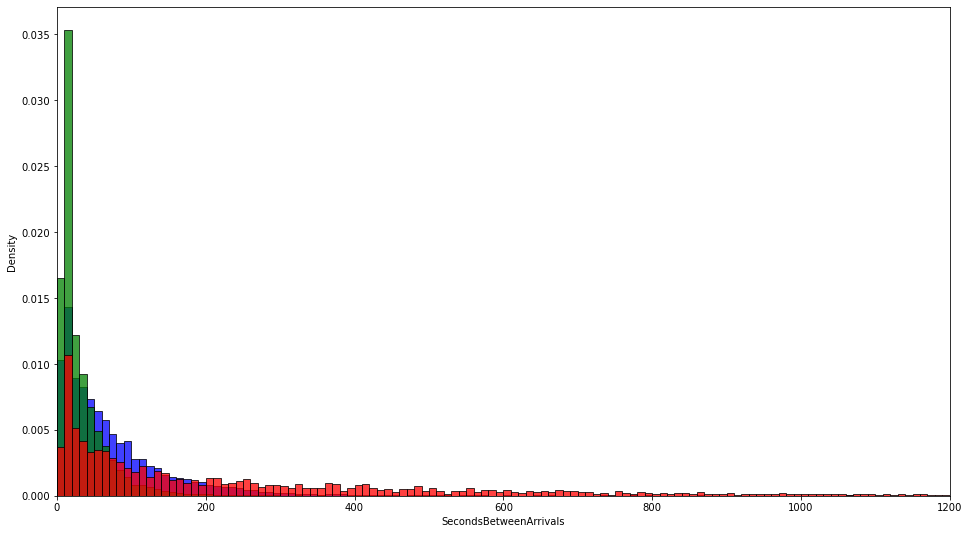

In [53]:
fig,ax = plt.subplots(figsize=(16,9))
ax.set_xlim(0,1200)

colors = ["b","g","r"]
i=0
for hour in [8,12,20]:

    x=parkings[(parkings["SecondsBetweenArrivals"]<=parkings["SecondsBetweenArrivals"].quantile(q=0.998)) & (parkings["EntryHour"]==hour)]["SecondsBetweenArrivals"]
    sns.histplot(x=x,kde=False,stat="density",color=colors[i],binwidth=10)
    
    i+=1

#ax.set_xlim(0,60)

In [105]:

import sklearn
from scipy.stats import norm
from sklearn.neighbors import KernelDensity
#from sklearn.utils.fixes import parse_version

In [128]:
bandwidth= 7
kde_dict_interarrival = dict()
for facility in ["Facility_KoeBogen"]:
    
    day_dict = dict()
    for day in ["Workday","Saturday","Sunday"]:

        hour_dict = dict()    
        for hour in range(0,24,1):

            data = parkings[(parkings["SecondsBetweenArrivals"]<=parkings["SecondsBetweenArrivals"].quantile(q=0.998))&
                            (parkings["EntryHour"]==hour) & 
                            (parkings["DayType"]==day)]

            #(parkings["SecondsBetweenArrivals"]<=parkings["SecondsBetweenArrivals"].quantile(q=0.998)) & 

            if len(data)>0:

                kde = KernelDensity(bandwidth=bandwidth, kernel='gaussian')
                kde.fit(np.array(data["SecondsBetweenArrivals"]).reshape(-1,1))

            else:
                kde="no samples"

            hour_dict[hour] = kde
        
        day_dict[day] = hour_dict
        
    kde_dict_interarrival[facility] = day_dict

In [129]:
type(kde_dict_interarrival[facility]["Workday"][22])==sklearn.neighbors._kde.KernelDensity

True

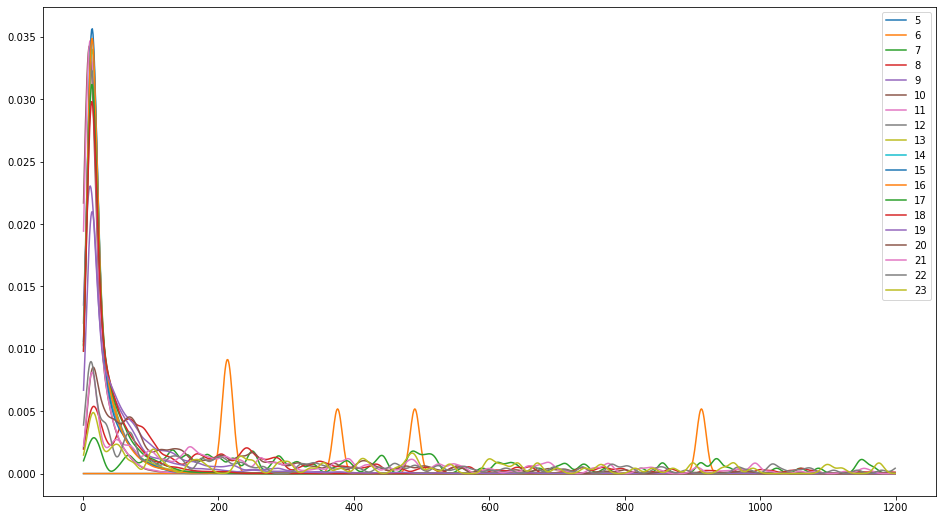

In [134]:
fig,ax=plt.subplots(figsize=(16,9))

values = np.asarray([value for value in range(1, 1200)])
values = values.reshape((len(values), 1))


for facility in ["Facility_KoeBogen"]:
    for day in ["Saturday"]: #,"Saturday","Sunday"
        for hour in range(5,24,1):
            
            kde = kde_dict_interarrival[facility][day][hour]
            
            if type(kde)==sklearn.neighbors._kde.KernelDensity:
            
                probabilities = kde.score_samples(values)
                probabilities = np.exp(probabilities)
                ax.plot(values[:], probabilities,label=hour)
                
ax.legend()

In [139]:
bandwidths = 10 ** np.linspace(-1, 1, 25)

In [140]:
bandwidths

array([ 0.1       ,  0.12115277,  0.14677993,  0.17782794,  0.21544347,
        0.26101572,  0.31622777,  0.38311868,  0.46415888,  0.56234133,
        0.68129207,  0.82540419,  1.        ,  1.21152766,  1.46779927,
        1.77827941,  2.15443469,  2.61015722,  3.16227766,  3.83118685,
        4.64158883,  5.62341325,  6.81292069,  8.25404185, 10.        ])

In [ ]:
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import LeaveOneOut

bandwidths = 10 ** np.linspace(-1, 1, 100)
grid = GridSearchCV(KernelDensity(kernel='gaussian'),
                    {'bandwidth': bandwidths},
                    cv=LeaveOneOut(len(x)))
grid.fit(x[:, None]);

In [131]:
kde = KernelDensity(bandwidth=2, kernel='gaussian')

In [44]:
kde.fit(np.array(parkings["SecondsBetweenArrivals"]).reshape(-1,1))

KernelDensity(bandwidth=2)

In [45]:
kde.sample(1)

array([[36.44703979]])

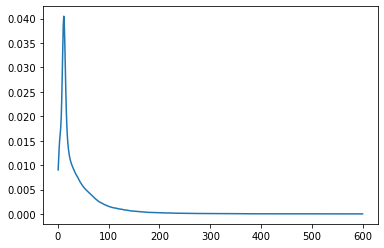

In [46]:
# fit density

#sample = sample.reshape((len(sample), 1))
#model.fit(saample)
# sample probabilities for a range of outcomes
values = np.asarray([value for value in range(1, 1200)])
values = values.reshape((len(values), 1))
probabilities = kde.score_samples(values)
probabilities = np.exp(probabilities)
# plot the histogram and pdf
#plt.hist(sample, bins=50, density=True)
plt.plot(values[:], probabilities)
plt.show()

### Arrival Rate Approach

In [142]:
# entries per minute
parkings["EntryDateHour"] = parkings["EntryDateTime"].apply(lambda x: x.replace(minute=0,second=0))

In [144]:
parkings.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'EntryDateTime', 'ExitDateTime',
       'HoursStay', 'MinutesStay', 'RevenueAmount', 'SiteID', 'Year',
       'EntryMFM', 'ExitMFM', 'EntryDate', 'ExitDate', 'EntryHour', 'ExitHour',
       'EntryHour_sin', 'EntryHour_cos', 'EntryMin_sin', 'EntryMin_cos',
       'ExitHour_sin', 'ExitHour_cos', 'ExitMin_sin', 'ExitMin_cos',
       'EntryDayOfWeek', 'EntryWeekday_yn', 'EntryHoliday_yn',
       'userInputs_WhPerMile', 'userInputs_kWhRequested',
       'userInputs_milesRequested', 'MaxFeasible_kwhRequested',
       'final_kWhRequested', 'Entry_shifted', 'TimeSinceLastEntry',
       'MinutesBetweenArrivals', 'SecondsBetweenArrivals', 'EntryDateHour',
       'DayType'],
      dtype='object')

In [156]:
parkings_per_hour = parkings[["EntryDateHour","EntryDateTime","SiteID"]].groupby(["EntryDateHour","SiteID"]).count()
parkings_per_hour.columns=["NumEntries"]
parkings_per_hour.reset_index()

,EntryDateHour,SiteID,NumEntries
0,2019-01-01 00:00:00,Facility_KoeBogen,16
1,2019-01-01 10:00:00,Facility_KoeBogen,2
2,2019-01-01 11:00:00,Facility_KoeBogen,3
3,2019-01-01 12:00:00,Facility_KoeBogen,2
4,2019-01-01 13:00:00,Facility_KoeBogen,5
...,...,...,...
6217,2019-12-31 19:00:00,Facility_KoeBogen,7
6218,2019-12-31 20:00:00,Facility_KoeBogen,10
6219,2019-12-31 21:00:00,Facility_KoeBogen,9
6220,2019-12-31 22:00:00,Facility_KoeBogen,32


In [167]:
target_df_final = pd.DataFrame([])
target_df = pd.DataFrame(index=pd.date_range(start=parkings["EntryDateTime"].min().replace(minute=0,second=0), end=parkings["EntryDateTime"].max().replace(minute=0,second=0), freq="H"))

for facility in ["Facility_KoeBogen"]:
    
    df=target_df
    df["SiteID"]=facility
    df.reset_index(inplace=True)
    df.columns=["EntryDateHour","SiteID"]
    
    target_df_final=target_df_final.append(df)

In [168]:
target_df_final

,EntryDateHour,SiteID
0,2019-01-01 00:00:00,Facility_KoeBogen
1,2019-01-01 01:00:00,Facility_KoeBogen
2,2019-01-01 02:00:00,Facility_KoeBogen
3,2019-01-01 03:00:00,Facility_KoeBogen
4,2019-01-01 04:00:00,Facility_KoeBogen
...,...,...
8755,2019-12-31 19:00:00,Facility_KoeBogen
8756,2019-12-31 20:00:00,Facility_KoeBogen
8757,2019-12-31 21:00:00,Facility_KoeBogen
8758,2019-12-31 22:00:00,Facility_KoeBogen


In [174]:
parkings_per_hour_full =target_df_final.merge(parkings_per_hour,how="left",on=["EntryDateHour", "SiteID"])

In [175]:
parkings_per_hour_full

,EntryDateHour,SiteID,NumEntries
0,2019-01-01 00:00:00,Facility_KoeBogen,16.0
1,2019-01-01 01:00:00,Facility_KoeBogen,NaN
2,2019-01-01 02:00:00,Facility_KoeBogen,NaN
3,2019-01-01 03:00:00,Facility_KoeBogen,NaN
4,2019-01-01 04:00:00,Facility_KoeBogen,NaN
...,...,...,...
8755,2019-12-31 19:00:00,Facility_KoeBogen,7.0
8756,2019-12-31 20:00:00,Facility_KoeBogen,10.0
8757,2019-12-31 21:00:00,Facility_KoeBogen,9.0
8758,2019-12-31 22:00:00,Facility_KoeBogen,32.0


In [19]:
parkings_per_hour_full = target_df.join(parkings_per_hour)
parkings_per_hour_full.fillna(0,inplace=True)
parkings_per_hour_full.reset_index(inplace=True)
parkings_per_hour_full.columns=["EntryDateHour","NumEntries"]
parkings_per_hour_full["VehiclesPerMinute"] = parkings_per_hour_full["NumEntries"]/60

In [20]:
parkings_per_hour_full["SiteID"] = facility
parkings_per_hour_full["EntryHour"] = parkings_per_hour_full["EntryDateHour"].apply(lambda x: x.hour)
parkings_per_hour_full["EntryDayOfWeek"] = parkings_per_hour_full["EntryDateHour"].apply(lambda x: x.weekday())
parkings_per_hour_full["EntryWeekday_yn"] = parkings_per_hour_full["EntryDayOfWeek"].apply(lambda x: 1 if x<5 else 0)

In [21]:
parkings_per_hour_full

,EntryDateHour,NumEntries,VehiclesPerMinute,SiteID,EntryHour,EntryDayOfWeek,EntryWeekday_yn
0,2019-01-01 00:00:00,16.0,0.266667,Facility_KoeBogen,0,1,1
1,2019-01-01 01:00:00,0.0,0.000000,Facility_KoeBogen,1,1,1
2,2019-01-01 02:00:00,0.0,0.000000,Facility_KoeBogen,2,1,1
3,2019-01-01 03:00:00,0.0,0.000000,Facility_KoeBogen,3,1,1
4,2019-01-01 04:00:00,0.0,0.000000,Facility_KoeBogen,4,1,1
...,...,...,...,...,...,...,...
8755,2019-12-31 19:00:00,7.0,0.116667,Facility_KoeBogen,19,1,1
8756,2019-12-31 20:00:00,10.0,0.166667,Facility_KoeBogen,20,1,1
8757,2019-12-31 21:00:00,9.0,0.150000,Facility_KoeBogen,21,1,1
8758,2019-12-31 22:00:00,32.0,0.533333,Facility_KoeBogen,22,1,1


In [63]:
parkings

,Unnamed: 0,Unnamed: 0.1,EntryDateTime,ExitDateTime,HoursStay,MinutesStay,RevenueAmount,SiteID,Year,EntryMFM,...,EntryHoliday_yn,userInputs_WhPerMile,userInputs_kWhRequested,userInputs_milesRequested,MaxFeasible_kwhRequested,final_kWhRequested,Entry_shifted,TimeSinceLastEntry,MinutesBetweenArrivals,SecondsBetweenArrivals
3477299,3477299,3512771,2019-01-01 00:01:34,2019-01-01 01:46:25,1.750000,105,5.6,Facility_KoeBogen,2019,1,...,1,322.583333,18.956667,67.500000,38.500000,18.956667,NaT,00:04:05,4.083333,245.0
3477300,3477300,3512772,2019-01-01 00:05:39,2019-01-01 03:59:50,3.900000,234,11.2,Facility_KoeBogen,2019,5,...,1,357.500000,19.791667,60.000000,85.800000,19.791667,2019-01-01 00:01:34,00:04:05,4.083333,245.0
3477301,3477301,3512773,2019-01-01 00:15:54,2019-01-01 01:18:52,1.050000,63,2.8,Facility_KoeBogen,2019,15,...,1,402.083333,23.639167,65.666667,23.100000,23.100000,2019-01-01 00:05:39,00:10:15,10.250000,615.0
3477302,3477302,3512774,2019-01-01 00:16:08,2019-01-01 06:40:34,6.400000,384,19.6,Facility_KoeBogen,2019,16,...,1,383.333333,24.247500,67.500000,140.800000,24.247500,2019-01-01 00:15:54,00:00:14,0.233333,14.0
3477303,3477303,3512775,2019-01-01 00:18:25,2019-01-01 01:22:16,1.066666,64,2.8,Facility_KoeBogen,2019,18,...,1,370.583333,19.742500,60.833333,23.466652,19.742500,2019-01-01 00:16:08,00:02:17,2.283333,137.0
3477304,3477304,3512776,2019-01-01 00:18:52,2019-01-01 01:32:28,1.233333,74,5.6,Facility_KoeBogen,2019,18,...,1,345.083333,21.692500,74.166667,27.133326,21.692500,2019-01-01 00:18:25,00:00:27,0.450000,27.0
3477305,3477305,3512777,2019-01-01 00:19:21,2019-01-01 04:11:52,3.866666,232,11.2,Facility_KoeBogen,2019,19,...,1,349.166667,25.122500,75.833333,85.066652,25.122500,2019-01-01 00:18:52,00:00:29,0.483333,29.0
3477306,3477306,3512778,2019-01-01 00:24:15,2019-01-01 00:36:24,0.200000,12,0.0,Facility_KoeBogen,2019,24,...,1,326.000000,37.412500,113.333333,4.400000,0.000000,2019-01-01 00:19:21,00:04:54,4.900000,294.0
3477307,3477307,3512779,2019-01-01 00:33:29,2019-01-01 04:28:40,3.916666,235,11.2,Facility_KoeBogen,2019,33,...,1,343.333333,21.802500,66.666667,86.166652,21.802500,2019-01-01 00:24:15,00:09:14,9.233333,554.0
3477308,3477308,3512780,2019-01-01 00:37:06,2019-01-01 00:39:58,0.033333,2,0.0,Facility_KoeBogen,2019,37,...,1,326.000000,37.412500,113.333333,0.733326,0.000000,2019-01-01 00:33:29,00:03:37,3.616667,217.0


In [ ]:
parkings

In [ ]:
for day in parkings[]

In [2]:
# Plotting

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

In [23]:
palette_1 = sns.color_palette("pastel")
palette_2 = sns.color_palette("mako", n_colors=5)
palette_4 = sns.color_palette("coolwarm", n_colors=9)
palette_3 = sns.color_palette("rocket", n_colors=5)

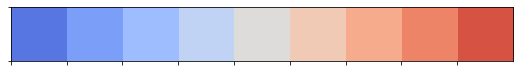

In [24]:
sns.palplot(palette_4)

In [25]:
plt.style.available

['seaborn-dark',
 'seaborn-darkgrid',
 'seaborn-ticks',
 'fivethirtyeight',
 'seaborn-whitegrid',
 'classic',
 '_classic_test',
 'fast',
 'seaborn-talk',
 'seaborn-dark-palette',
 'seaborn-bright',
 'seaborn-pastel',
 'grayscale',
 'seaborn-notebook',
 'ggplot',
 'seaborn-colorblind',
 'seaborn-muted',
 'seaborn',
 'Solarize_Light2',
 'seaborn-paper',
 'bmh',
 'tableau-colorblind10',
 'seaborn-white',
 'dark_background',
 'seaborn-poster',
 'seaborn-deep']

In [38]:
project_even_cols = [[44/255,25/255,149/255,.8],[147/255,41/255,223/255,.8],[0/255,9/255,43/255,.8]]

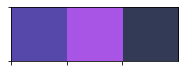

In [39]:
sns.palplot(project_even_cols)

In [71]:
import pandas as pd
import numpy as np
import os
from datetime import datetime, timedelta

In [72]:
test_data = pd.read_csv("/Users/schroerk/Code/Research/EVCC_Sim/Results/raw_output/testing.csv")

In [74]:
test_data.head(10)

,Unnamed: 0,EntryDateTime,ExitDateTime,HoursStay,MinutesStay,RevenueAmount,SiteID,Year,EntryDate,DayType,...,FacilityType,StayDuration,StayDurationMinutes,EntryMinutesFromSimStart,ExitMinutesFromSimStart,EntryDateTime5min,ExitDateTime5min,EV_yn,final_kWhRequested_updated,BatterySize
0,0,2019-06-03 04:26:03,2019-06-03 14:23:28,9.950000,597,0.0,Facility_3,2019,2019-06-03 00:00:00,Workday,...,Mixed-use_Facility,0 days 09:57:25.000000000,597.416667,266.050000,863.466667,2019-06-03 04:25:00,2019-06-03 14:20:00,0,0.000000,NaN
1,1,2019-06-03 04:42:40,2019-06-03 11:25:41,6.716666,403,0.0,Facility_3,2019,2019-06-03 00:00:00,Workday,...,Mixed-use_Facility,0 days 06:43:01.000000000,403.016667,282.666667,685.683333,2019-06-03 04:40:00,2019-06-03 11:25:00,0,0.000000,NaN
2,2,2019-06-03 04:42:49,2019-06-03 15:27:10,10.750000,645,0.0,Facility_3,2019,2019-06-03 00:00:00,Workday,...,Mixed-use_Facility,0 days 10:44:21.000000000,644.350000,282.816667,927.166667,2019-06-03 04:40:00,2019-06-03 15:25:00,0,0.000000,NaN
3,3,2019-06-03 04:53:37,2019-06-03 06:08:59,1.250000,75,0.0,Facility_3,2019,2019-06-03 00:00:00,Workday,...,Mixed-use_Facility,0 days 01:15:22.000000000,75.366667,293.616667,368.983333,2019-06-03 04:50:00,2019-06-03 06:05:00,0,0.000000,NaN
4,4,2019-06-03 05:04:33,2019-06-03 15:26:01,10.366666,622,0.0,Facility_3,2019,2019-06-03 00:00:00,Workday,...,Mixed-use_Facility,0 days 10:21:28.000000000,621.466667,304.550000,926.016667,2019-06-03 05:00:00,2019-06-03 15:25:00,0,0.000000,NaN
5,5,2019-06-03 05:09:16,2019-06-03 15:22:57,10.216666,613,0.0,Facility_3,2019,2019-06-03 00:00:00,Workday,...,Mixed-use_Facility,0 days 10:13:41.000000000,613.683333,309.266667,922.950000,2019-06-03 05:05:00,2019-06-03 15:20:00,0,0.000000,NaN
6,6,2019-06-03 05:12:56,2019-06-03 15:16:20,10.066666,604,0.0,Facility_3,2019,2019-06-03 00:00:00,Workday,...,Mixed-use_Facility,0 days 10:03:24.000000000,603.400000,312.933333,916.333333,2019-06-03 05:10:00,2019-06-03 15:15:00,1,29.330833,64.5
7,7,2019-06-03 05:13:07,2019-06-03 12:42:09,7.483333,449,0.0,Facility_3,2019,2019-06-03 00:00:00,Workday,...,Mixed-use_Facility,0 days 07:29:02.000000000,449.033333,313.116667,762.150000,2019-06-03 05:10:00,2019-06-03 12:40:00,1,38.135833,30.0
8,8,2019-06-03 05:20:04,2019-06-03 13:56:22,8.600000,516,0.0,Facility_3,2019,2019-06-03 00:00:00,Workday,...,Mixed-use_Facility,0 days 08:36:18.000000000,516.300000,320.066667,836.366667,2019-06-03 05:20:00,2019-06-03 13:55:00,1,19.306667,40.0
9,9,2019-06-03 05:21:26,2019-06-03 15:47:00,10.433333,626,0.0,Facility_3,2019,2019-06-03 00:00:00,Workday,...,Mixed-use_Facility,0 days 10:25:34.000000000,625.566667,321.433333,947.000000,2019-06-03 05:20:00,2019-06-03 15:45:00,1,28.793333,30.0


In [64]:
sim_start_day='2019-06-03'
sim_duration=3

In [65]:
start_day = pd.to_datetime(sim_start_day)
end_day = start_day + timedelta(days=sim_duration)
candidate_dates_list = list(pd.date_range(start=start_day, end=end_day, freq="D"))

In [52]:
end_day.isin(candidate_dates_list)

AttributeError: 'Timestamp' object has no attribute 'isin'

In [56]:
candidate_dates_list[0] == start_day

True

In [61]:
start_day

Timestamp('2019-06-03 00:00:00')

In [68]:
def time_delta_to_scalar_minutes(td):
    """
    Converts time delta to scalar minutes
    :param td: time delta
    :return: total_minutes (scalar)
    """
    full_minutes, seconds = divmod(td.seconds, 60)

    total_minutes = td.days*24*60 + full_minutes + seconds / 60 #td.days*24*60 +

    return total_minutes

In [69]:
time_delta_to_scalar_minutes(end_day-start_day)

4320.0